In [ ]:
# =============================================================================
# SETUP AMBIENTE E CARICAMENTO DATI (APPROCCIO 3)
# 1. Installazione libreria dtaidistance per calcolo DTW.
# 2. Definizione funzioni di caricamento dati (Primi 100ms).
# =============================================================================

try:
    import dtaidistance
except ImportError:
    !pip install dtaidistance

from google.colab import drive
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from dtaidistance import dtw
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

# Montaggio Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# --- FUNZIONI DI CARICAMENTO ---
def load_transient_data_lb(excel_path, data_folder, is_train=True, window_size=100):
    print(f"Caricamento dati da: {data_folder}...")
    try:
        df_labels = pd.read_excel(excel_path, header=1)
    except:
        df_labels = pd.read_excel(excel_path, header=0)

    cols = list(df_labels.columns)
    mapping = {}
    if len(cols) >= 1: mapping[cols[0]] = 'Case#'
    if len(cols) >= 2: mapping[cols[1]] = 'Spacecraft#'
    if len(cols) >= 3 and is_train: mapping[cols[2]] = 'Condition'
    df_labels = df_labels.rename(columns=mapping)
    df_labels = df_labels.dropna(subset=['Case#'])

    all_data = []
    for index, row in df_labels.iterrows():
        try:
            case_id = int(row['Case#'])
            filename_pad = f"Case{case_id:03d}.csv"
            filename_nopad = f"Case{case_id}.csv"

            file_path = os.path.join(data_folder, filename_pad)
            if not os.path.exists(file_path):
                file_path = os.path.join(data_folder, filename_nopad)

            if os.path.exists(file_path):
                df_signals = pd.read_csv(file_path, nrows=window_size)
                new_row = row.to_dict()

                for s in ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']:
                    vals = df_signals[s].values if s in df_signals.columns else np.zeros(window_size)
                    if len(vals) < window_size:
                        vals = np.pad(vals, (0, window_size - len(vals)), 'edge')
                    new_row[f"{s}_vec"] = vals

                # --- GESTIONE TARGET (CORRETTA) ---
                if is_train:
                    cond = str(row['Condition']).lower()
                    new_row['Target_Task1'] = 0 if 'normal' in cond else 1
                    new_row['Target_Task2'] = 0
                    new_row['Target_Task3'] = 0
                    new_row['Target_Task4'] = 0
                    new_row['Target_Task5'] = 100.0 # <--- DEFAULT: Apertura 100%

                    if 'anomaly' in cond:
                        new_row['Target_Task2'] = 2
                        for i, bp in enumerate(['BP1','BP2','BP3','BP4','BP5','BP6','BP7','BV1']):
                            if bp in df_labels.columns and str(row[bp]).lower() in ['yes', 'x', '1']:
                                new_row['Target_Task3'] = i + 1

                    elif 'fault' in cond:
                        new_row['Target_Task2'] = 3
                        for i, sv in enumerate(['SV1','SV2','SV3','SV4']):
                            # Cerchiamo la colonna della valvola che ha un valore numerico < 100
                            if sv in df_labels.columns:
                                val = row[sv]
                                if pd.notnull(val) and isinstance(val, (int, float)) and val < 100:
                                    new_row['Target_Task4'] = i + 1
                                    new_row['Target_Task5'] = float(val) # <--- SALVIAMO L'APERTURA REALE
                                    break

                all_data.append(new_row)
        except Exception as e:
            continue

    return pd.DataFrame(all_data)

# --- PERCORSI E CARICAMENTO ---
PATH_TRAIN_XL = "/content/drive/MyDrive/train/labels.xlsx"
PATH_TRAIN_DATA = "/content/drive/MyDrive/train/data/"
PATH_TEST_XL = "/content/drive/MyDrive/test/labels_spacecraft.xlsx"
PATH_TEST_DATA = "/content/drive/MyDrive/test/data/"

df_train_lb = load_transient_data_lb(PATH_TRAIN_XL, PATH_TRAIN_DATA, is_train=True)
df_test_lb = load_transient_data_lb(PATH_TEST_XL, PATH_TEST_DATA, is_train=False)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 39.8 MB/s eta 0:00:00
Mounted at /content/drive
Caricamento dati da: /content/drive/MyDrive/Manutenzione/train/data/...
Caricamento dati da: /content/drive/MyDrive/Manutenzione/test/data/...

✅ Dataset caricati in memoria.
Train size: 177 | Test size: 46
Verifica Target 5: [100.   0.  25.  50.  75.]


--- RISULTATI ANALITICI CROSS-VALIDATION: TASK 1 ---
🔹 Dati analizzati: 177 casi totali (Normali vs Anomali)
🔹 Metodo: Distanza DTW su sensore P1
🔹 Accuratezza Globale CV: 100.00%
🔹 Soglia di Anomalia media stimata: 0.0000


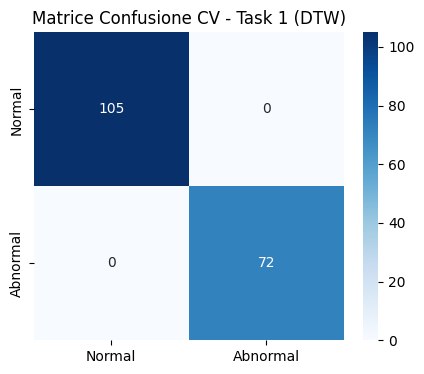

In [ ]:
# =============================================================================
# TASK 1: CROSS-VALIDATION (DTW ANOMALY DETECTION)
# =============================================================================
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = df_train_lb.index.values
y = df_train_lb['Target_Task1'].values

y_true_all, y_pred_all = [], []
thresholds = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    train_set = df_train_lb.iloc[train_idx]
    val_set = df_train_lb.iloc[val_idx]

    # Template Normale e Soglia
    normals_train = train_set[train_set['Target_Task1'] == 0]
    template_P1 = np.mean(np.stack(normals_train['P1_vec'].values), axis=0)

    dists_normal = [dtw.distance(row['P1_vec'], template_P1) for _, row in normals_train.iterrows()]
    thresh = np.mean(dists_normal) + 3 * np.std(dists_normal)
    thresholds.append(thresh)

    # Test sul fold
    for _, row in val_set.iterrows():
        d = dtw.distance(row['P1_vec'], template_P1)
        y_pred_all.append(1 if d > thresh else 0)
        y_true_all.append(row['Target_Task1'])

# --- OUTPUT ANALITICO STANDARDIZZATO ---
acc = accuracy_score(y_true_all, y_pred_all)
print(f"--- RISULTATI ANALITICI CROSS-VALIDATION: TASK 1 ---")
print(f"🔹 Dati analizzati: {len(y)} casi totali (Normali vs Anomali)")
print(f"🔹 Metodo: Distanza DTW su sensore P1")
print(f"🔹 Accuratezza Globale CV: {acc*100:.2f}%")
print(f"🔹 Soglia di Anomalia media stimata: {np.mean(thresholds):.4f}")

cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Matrice Confusione CV - Task 1 (DTW)')
plt.show()

In [ ]:
# =============================================================================
# TASK 1: PREDIZIONE TEST SET (DTW)
# 1. Calcolo Template e Soglia su TUTTO il training set.
# 2. Applicazione al Test Set.
# =============================================================================

# 1. Training su tutto il dataset
normals_full = df_train_lb[df_train_lb['Target_Task1'] == 0]
FULL_TEMPLATE_P1 = np.mean(np.stack(normals_full['P1_vec'].values), axis=0)

dists_full = [dtw.distance(row['P1_vec'], FULL_TEMPLATE_P1) for _, row in normals_full.iterrows()]
FINAL_THRESHOLD_T1 = np.mean(dists_full) + 3 * np.std(dists_full)

print(f"Soglia Finale Task 1: {FINAL_THRESHOLD_T1:.4f}")

# 2. Predizione
test_preds_t1 = []
test_dists_t1 = []

for _, row in df_test_lb.iterrows():
    d = dtw.distance(row['P1_vec'], FULL_TEMPLATE_P1)
    test_dists_t1.append(d)
    test_preds_t1.append(1 if d > FINAL_THRESHOLD_T1 else 0)

df_test_lb['Task1_Pred'] = test_preds_t1
df_test_lb['DTW_Dist_Normal'] = test_dists_t1

# Analisi
print("\nDistribuzione Predizioni Task 1 (Test Set):")
print(df_test_lb['Task1_Pred'].value_counts().rename({0: 'Normal', 1: 'Abnormal'}))

print("\nSuddivisione per Spacecraft:")
print(pd.crosstab(df_test_lb['Spacecraft#'], df_test_lb['Task1_Pred']).rename(columns={0: 'Normal', 1: 'Abnormal'}))

Soglia Finale Task 1: 0.0000

Distribuzione Predizioni Task 1 (Test Set):
Task1_Pred
Abnormal    26
Normal      20
Name: count, dtype: int64

Suddivisione per Spacecraft:
Task1_Pred   Normal  Abnormal
Spacecraft#                  
1                10        13
4                10        13


--- RISULTATI ANALITICI CROSS-VALIDATION: TASK 2 ---
🔹 Dati analizzati: 72 casi anomali (Bolle vs Valvole)
🔹 Metodo: 1-Nearest Neighbor DTW su sensori P1 + P6
🔹 Accuratezza Globale CV: 100.00%
🔹 Soglia per identificare guasti 'Unknown': 0.8505


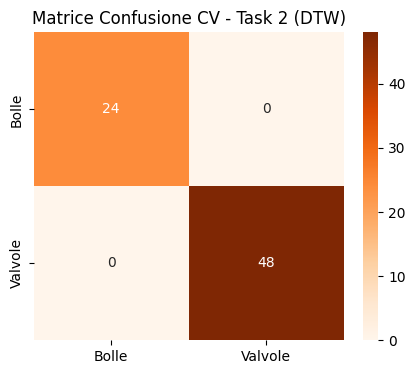

In [ ]:
# =============================================================================
# TASK 2: CROSS-VALIDATION (DTW 1-NN CLASSIFICATION)
# =============================================================================
df_anom = df_train_lb[df_train_lb['Target_Task1'] == 1].copy()
X = df_anom.index.values
y = df_anom['Target_Task2'].values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_true_all, y_pred_all = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    train_set = df_anom.iloc[train_idx]
    val_set = df_anom.iloc[val_idx]

    for _, val_row in val_set.iterrows():
        best_dist = float('inf')
        best_label = -1
        for _, train_row in train_set.iterrows():
            d = dtw.distance(val_row['P1_vec'], train_row['P1_vec']) + dtw.distance(val_row['P6_vec'], train_row['P6_vec'])
            if d < best_dist:
                best_dist, best_label = d, train_row['Target_Task2']

        y_pred_all.append(best_label)
        y_true_all.append(val_row['Target_Task2'])

# Calcolo Soglia Unknown (su tutto il set anomalo)
distances =[dtw.distance(df_anom.iloc[i]['P1_vec'], df_anom.iloc[j]['P1_vec']) for i in range(len(df_anom)) for j in range(i+1, len(df_anom))]
THRESHOLD_UNKNOWN = np.mean(distances) + 2*np.std(distances)

# --- OUTPUT ANALITICO STANDARDIZZATO ---
acc = accuracy_score(y_true_all, y_pred_all)
print(f"--- RISULTATI ANALITICI CROSS-VALIDATION: TASK 2 ---")
print(f"🔹 Dati analizzati: {len(y)} casi anomali (Bolle vs Valvole)")
print(f"🔹 Metodo: 1-Nearest Neighbor DTW su sensori P1 + P6")
print(f"🔹 Accuratezza Globale CV: {acc*100:.2f}%")
print(f"🔹 Soglia per identificare guasti 'Unknown': {THRESHOLD_UNKNOWN:.4f}")

cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Bolle', 'Valvole'], yticklabels=['Bolle', 'Valvole'])
plt.title('Matrice Confusione CV - Task 2 (DTW)')
plt.show()

In [ ]:
# =============================================================================
# TASK 2: PREDIZIONE TEST SET (DTW 1-NN)
# 1. Confronto ogni anomalia test con TUTTE le anomalie training.
# 2. Assegnazione classe del vicino più prossimo.
# 3. Gestione Unknown se la distanza minima > Soglia.
# =============================================================================

# Prendiamo solo quelli predetti anomali dal Task 1
mask_anom = df_test_lb['Task1_Pred'] == 1
test_anomalies = df_test_lb[mask_anom]

# Dataset di riferimento (Tutte le anomalie note)
train_anomalies_full = df_train_lb[df_train_lb['Target_Task1'] == 1]

preds_t2 = []

print(f"Classificazione di {len(test_anomalies)} anomalie nel test set...")

for idx, row in test_anomalies.iterrows():
    best_dist = float('inf')
    best_match_idx = -1

    # 1-NN Search
    for train_idx, train_row in train_anomalies_full.iterrows():
        d = dtw.distance(row['P1_vec'], train_row['P1_vec']) + \
            dtw.distance(row['P6_vec'], train_row['P6_vec'])

        if d < best_dist:
            best_dist = d
            best_match_idx = train_idx

    # Logica Unknown
    # Usiamo la distanza su P1 normalizzata rispetto al template normale per coerenza
    dist_from_normal = row['DTW_Dist_Normal']

    # Se è troppo diverso anche dal normale medio e dai guasti, cioè la distanze è enorme, potrebbe essere Unknown

    # Prendiamo la classe del vicino
    nearest_label = train_anomalies_full.loc[best_match_idx, 'Target_Task2']

    # La soglia è su P1.
    dist_p1_nearest = dtw.distance(row['P1_vec'], train_anomalies_full.loc[best_match_idx, 'P1_vec'])

    if dist_p1_nearest > THRESHOLD_UNKNOWN:
        preds_t2.append(1) # Unknown
    else:
        preds_t2.append(nearest_label)

# Salvataggio
df_test_lb.loc[mask_anom, 'Task2_Pred'] = preds_t2
df_test_lb.loc[~mask_anom, 'Task2_Pred'] = 0

print("\nRisultati Task 2 (Test Set):")
print(df_test_lb['Task2_Pred'].value_counts().rename({0: 'Normal', 1: 'Unknown', 2: 'Bolle', 3: 'Valvole'}))

Classificazione di 26 anomalie nel test set...

Risultati Task 2 (Test Set):
Task2_Pred
Normal     20
Bolle      10
Valvole    10
Unknown     6
Name: count, dtype: int64


--- RISULTATI ANALITICI CROSS-VALIDATION: TASK 3 ---
🔹 Dati analizzati: 24 casi di 'Bubble Anomaly' (8 posizioni)
🔹 Metodo: 1-Nearest Neighbor DTW su sensore P1
🔹 Accuratezza Globale CV: 100.00%


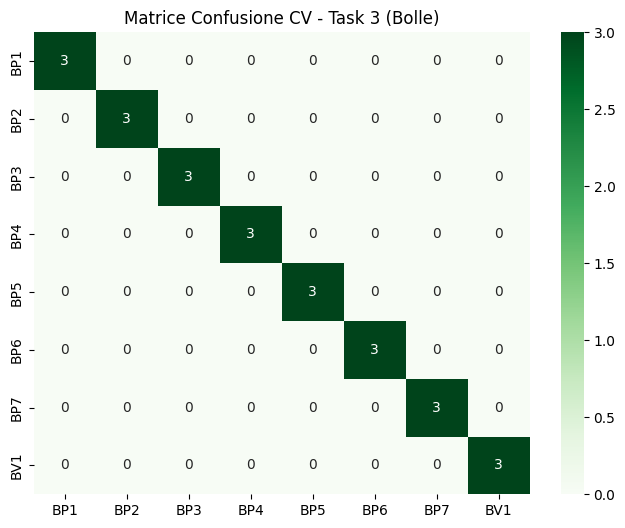

In [ ]:
# =============================================================================
# TASK 3: CROSS-VALIDATION (LOCALIZZAZIONE BOLLE - DTW)
# =============================================================================
df_bubbles = df_train_lb[df_train_lb['Target_Task2'] == 2].copy()
X = df_bubbles.index.values
y = df_bubbles['Target_Task3'].values

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 3-Fold per pochi dati
y_true_all, y_pred_all = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    train_set = df_bubbles.iloc[train_idx]
    val_set = df_bubbles.iloc[val_idx]

    for _, val_row in val_set.iterrows():
        best_dist = float('inf')
        best_loc = -1
        for _, train_row in train_set.iterrows():
            d = dtw.distance(val_row['P1_vec'], train_row['P1_vec'])
            if d < best_dist:
                best_dist, best_loc = d, train_row['Target_Task3']

        y_pred_all.append(best_loc)
        y_true_all.append(val_row['Target_Task3'])

# --- OUTPUT ANALITICO STANDARDIZZATO ---
acc = accuracy_score(y_true_all, y_pred_all)
print(f"--- RISULTATI ANALITICI CROSS-VALIDATION: TASK 3 ---")
print(f"🔹 Dati analizzati: {len(y)} casi di 'Bubble Anomaly' (8 posizioni)")
print(f"🔹 Metodo: 1-Nearest Neighbor DTW su sensore P1")
print(f"🔹 Accuratezza Globale CV: {acc*100:.2f}%")

labels_map = [f'BP{i}' for i in range(1, 8)] + ['BV1']
cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels_map, yticklabels=labels_map)
plt.title('Matrice Confusione CV - Task 3 (Bolle)')
plt.show()

In [ ]:
# =============================================================================
# TASK 3: PREDIZIONE TEST SET (DTW)
# =============================================================================

mask_bubbles = df_test_lb['Task2_Pred'] == 2
test_bubbles = df_test_lb[mask_bubbles]
train_bubbles_full = df_train_lb[df_train_lb['Target_Task2'] == 2]

preds_t3 = []

if len(test_bubbles) > 0:
    print(f"Localizzazione di {len(test_bubbles)} bolle nel test set...")
    for _, row in test_bubbles.iterrows():
        best_dist = float('inf')
        best_loc = -1

        for _, train_row in train_bubbles_full.iterrows():
            d = dtw.distance(row['P1_vec'], train_row['P1_vec'])
            if d < best_dist:
                best_dist = d
                best_loc = train_row['Target_Task3']
        preds_t3.append(best_loc)

    df_test_lb.loc[mask_bubbles, 'Task3_Pred'] = preds_t3

    # Report Analitico
    print("\nLocalizzazioni Trovate:")
    labels_map = ['N/A'] + [f'BP{i}' for i in range(1, 8)] + ['BV1']
    mapped_preds = [labels_map[int(p)] for p in preds_t3]
    print(pd.Series(mapped_preds).value_counts())
else:
    print("Nessuna bolla da localizzare.")

Localizzazione di 10 bolle nel test set...

Localizzazioni Trovate:
BP2    2
BP1    2
BP7    2
BP6    1
BP4    1
BP3    1
BP5    1
Name: count, dtype: int64


--- RISULTATI ANALITICI CROSS-VALIDATION: TASK 4 ---
🔹 Dati analizzati: 48 casi di 'Valve Fault' (SV1-SV4)
🔹 Metodo: 1-Nearest Neighbor DTW su sensori P1 + P6
🔹 Accuratezza Globale CV: 100.00%


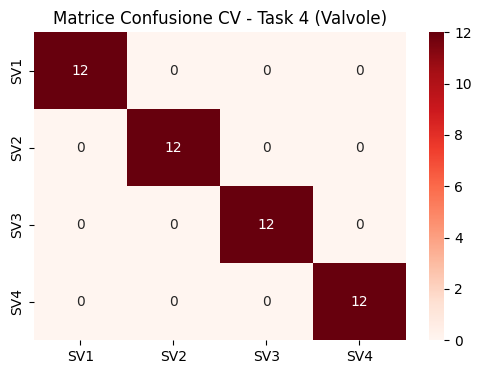

In [ ]:
# =============================================================================
# TASK 4: CROSS-VALIDATION (LOCALIZZAZIONE VALVOLE - DTW)
# =============================================================================
df_valves = df_train_lb[df_train_lb['Target_Task2'] == 3].copy()
X = df_valves.index.values
y = df_valves['Target_Task4'].values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_true_all, y_pred_all = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    train_set = df_valves.iloc[train_idx]
    val_set = df_valves.iloc[val_idx]

    for _, val_row in val_set.iterrows():
        best_dist = float('inf')
        best_loc = -1
        for _, train_row in train_set.iterrows():
            # P1 e P6 combinati per localizzare
            d = dtw.distance(val_row['P1_vec'], train_row['P1_vec']) + dtw.distance(val_row['P6_vec'], train_row['P6_vec'])
            # Somma delle distanze DTW per i sensori P3, P4, P6, P7
            #d = dtw.distance(val_row['P3_vec'], train_row['P3_vec']) + \
            #dtw.distance(val_row['P4_vec'], train_row['P4_vec']) + \
            #dtw.distance(val_row['P6_vec'], train_row['P6_vec']) + \
            #dtw.distance(val_row['P7_vec'], train_row['P7_vec'])

            if d < best_dist:
                best_dist, best_loc = d, train_row['Target_Task4']

        y_pred_all.append(best_loc)
        y_true_all.append(val_row['Target_Task4'])

# --- OUTPUT ANALITICO STANDARDIZZATO ---
acc = accuracy_score(y_true_all, y_pred_all)
print(f"--- RISULTATI ANALITICI CROSS-VALIDATION: TASK 4 ---")
print(f"🔹 Dati analizzati: {len(y)} casi di 'Valve Fault' (SV1-SV4)")
print(f"🔹 Metodo: 1-Nearest Neighbor DTW su sensori P1 + P6")
#print(f"🔹 Metodo: 1-Nearest Neighbor DTW su sensori P3 + P4 + P6 + P7")
print(f"🔹 Accuratezza Globale CV: {acc*100:.2f}%")

labels_map = [f'SV{i}' for i in range(1, 5)]
cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels_map, yticklabels=labels_map)
plt.title('Matrice Confusione CV - Task 4 (Valvole)')
plt.show()

In [ ]:
# =============================================================================
# TASK 4: PREDIZIONE TEST SET (DTW)
# =============================================================================

mask_valves = df_test_lb['Task2_Pred'] == 3
test_valves = df_test_lb[mask_valves]
train_valves_full = df_train_lb[df_train_lb['Target_Task2'] == 3]

preds_t4 = []

if len(test_valves) > 0:
    print(f"Localizzazione di {len(test_valves)} valvole nel test set...")
    for _, row in test_valves.iterrows():
        best_dist = float('inf')
        best_loc = -1

        for _, train_row in train_valves_full.iterrows():
            d = dtw.distance(row['P1_vec'], train_row['P1_vec']) + dtw.distance(row['P6_vec'], train_row['P6_vec'])
             # Somma delle distanze DTW per i sensori P3, P4, P6, P7
            # d = dtw.distance(val_row['P3_vec'], train_row['P3_vec']) + dtw.distance(val_row['P4_vec'], train_row['P4_vec']) + dtw.distance(val_row['P6_vec'], train_row['P6_vec']) + dtw.distance(val_row['P7_vec'], train_row['P7_vec'])

            if d < best_dist:
                best_dist = d
                best_loc = train_row['Target_Task4']
        preds_t4.append(best_loc)

    df_test_lb.loc[mask_valves, 'Task4_Pred'] = preds_t4

    # Report Analitico
    print("\nValvole Identificate:")
    labels_map = ['N/A'] + [f'SV{i}' for i in range(1, 5)]
    mapped_preds = [labels_map[int(p)] for p in preds_t4]
    print(pd.Series(mapped_preds).value_counts())
else:
    print("Nessun guasto valvola da localizzare.")

Localizzazione di 10 valvole nel test set...

Valvole Identificate:
SV2    4
SV4    2
SV1    2
SV3    2
Name: count, dtype: int64


Esempi totali per la regressione: 153
Target medi (aperture): [  0.  25.  50.  75. 100.]%

Avvio Cross-Validation (5 Folds) con XGBoost...

--- RISULTATI ANALITICI TASK 5 (XGBoost) ---
MAE Medio (Errore medio di apertura): 0.01%
Deviazione Standard Errore: (+/- 0.02%)


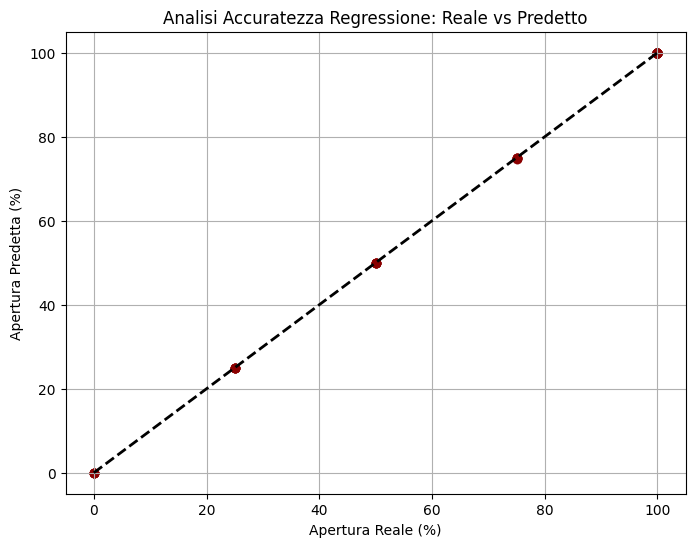


Addestramento finale del modello XGBoost su tutto il set...

Top 5 Feature che influenzano la stima dell'apertura:
1. P5_Min (0.6336)
2. P1_DeltaP (0.1099)
3. P2_Min (0.0687)
4. P3_Slope (0.0668)
5. P2_Mean (0.0531)

✅ Stima severità completata per 10 casi nel test set.


In [ ]:
# =============================================================================
# TASK 5: TRAINING & VALIDAZIONE (XGBOOST CON OUTPUT ANALITICO COMPLETO)
# =============================================================================

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_predict, cross_validate
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. FUNZIONE ESTRAZIONE FEATURE ESTESA
def extract_extended_features(df_rows, valve_col_name):
    feature_list = []
    sensor_names = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']
    for _, row in df_rows.iterrows():
        f = []
        for s in sensor_names:
            sig = row[f'{s}_vec'][:100]
            f.append(np.mean(sig))
            f.append(np.std(sig))
            f.append(np.max(sig) - np.min(sig))
            f.append(np.min(sig))
            f.append(np.gradient(sig).mean())
        # Usa il nome della colonna passato (Target_Task4 o Task4_Pred)
        f.append(row[valve_col_name])
        feature_list.append(f)
    return np.array(feature_list)

# 2. PREPARAZIONE DATASET TRAINING (Guasti + Normali al 100%)
df_valves = df_train_lb[df_train_lb['Target_Task2'] == 3].copy()
df_normal_reg = df_train_lb[df_train_lb['Target_Task1'] == 0].copy()
df_normal_reg['Target_Task5'] = 100.0
df_reg_complete = pd.concat([df_valves, df_normal_reg]).reset_index(drop=True)

# Nomi per la Feature Importance
stat_names = ['Mean', 'Std', 'DeltaP', 'Min', 'Slope']
feature_names = [f"{s}_{st}" for s in ['P1','P2','P3','P4','P5','P6','P7'] for st in stat_names] + ['Valve_ID']

X_reg = extract_extended_features(df_reg_complete, 'Target_Task4')
y_reg = df_reg_complete['Target_Task5'].values

print(f"Esempi totali per la regressione: {len(df_reg_complete)}")
print(f"Target medi (aperture): {np.sort(np.unique(y_reg))}%")

# 3. CONFIGURAZIONE CROSS-VALIDATION (5-Fold K-Fold)
cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)
reg_t5 = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    objective='reg:squarederror',
    random_state=42
)

print("\nAvvio Cross-Validation (5 Folds) con XGBoost...")

# 4. ESECUZIONE VALIDAZIONE E CALCOLO METRICHE
cv_results = cross_validate(reg_t5, X_reg, y_reg, cv=cv_reg,
                            scoring='neg_mean_absolute_error',
                            return_train_score=False)

mae_scores = -cv_results['test_score']

print(f"\n--- RISULTATI ANALITICI TASK 5 (XGBoost) ---")
print(f"MAE Medio (Errore medio di apertura): {mae_scores.mean():.2f}%")
print(f"Deviazione Standard Errore: (+/- {mae_scores.std():.2f}%)")

# Generiamo le predizioni in CV per il grafico Reale vs Predetto
y_pred_cv = cross_val_predict(reg_t5, X_reg, y_reg, cv=cv_reg)

# 5. ANALISI VISUALE: REALTÀ VS PREDIZIONE
plt.figure(figsize=(8, 6))
plt.scatter(y_reg, y_pred_cv, alpha=0.5, color='darkred')
plt.plot([y_reg.min(), y_reg.max()], [y_reg.min(), y_reg.max()], 'k--', lw=2)
plt.xlabel('Apertura Reale (%)')
plt.ylabel('Apertura Predetta (%)')
plt.title('Analisi Accuratezza Regressione: Reale vs Predetto')
plt.grid(True)
plt.show()

# 6. ADDESTRAMENTO FINALE E FEATURE IMPORTANCE
print("\nAddestramento finale del modello XGBoost su tutto il set...")
reg_t5.fit(X_reg, y_reg)

importances = reg_t5.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nTop 5 Feature che influenzano la stima dell'apertura:")
for f in range(5):
    print(f"{f+1}. {feature_names[indices[f]]} ({importances[indices[f]]:.4f})")

# 7. PREDIZIONE TEST SET
mask_test = df_test_lb['Task2_Pred'] == 3
if mask_test.any():
    indices_test = df_test_lb[mask_test].index
    X_test = extract_extended_features(df_test_lb.loc[indices_test], 'Task4_Pred')
    df_test_lb.loc[indices_test, 'Task5_Pred'] = np.clip(reg_t5.predict(X_test), 0, 100)
    print(f"\n✅ Stima severità completata per {len(indices_test)} casi nel test set.")

In [ ]:
# =============================================================================
# TASK 5: XGBOOST CON FEATURE RANKING (P3, P4, P6, P7) E ONE-HOT ENCODING
# =============================================================================

import xgboost as xgb
from sklearn.model_selection import KFold, cross_validate
import numpy as np
import pandas as pd

# 1. FUNZIONE ESTRAZIONE FEATURE CON ONE-HOT ENCODING DELLA VALVOLA
def extract_task5_features(df_rows, valve_col_name):
    feature_list = []
    selected_sensors = ['P3', 'P4', 'P6', 'P7']

    for _, row in df_rows.iterrows():
        f = []
        # Feature dai sensori scelti
        for s in selected_sensors:
            sig = row[f'{s}_vec'][:100]
            f.append(np.mean(sig))
            f.append(np.std(sig))
            f.append(np.max(sig) - np.min(sig))
            f.append(np.min(sig))
            f.append(np.gradient(sig).mean())

        # COORDINATE SPAZIALI: Creiamo 4 feature binarie (SV1, SV2, SV3, SV4)
        # Se è un caso normale, saranno tutte a 0.
        v_id = row[valve_col_name]
        f.append(1 if v_id == 1 else 0) # SV1
        f.append(1 if v_id == 2 else 0) # SV2
        f.append(1 if v_id == 3 else 0) # SV3
        f.append(1 if v_id == 4 else 0) # SV4

        feature_list.append(f)
    return np.array(feature_list)

# 2. PREPARAZIONE DATASET DI TRAIN
df_valves_tr = df_train_lb[df_train_lb['Target_Task2'] == 3].copy()
df_normal_tr = df_train_lb[df_train_lb['Target_Task1'] == 0].copy()
df_normal_tr['Target_Task5'] = 100.0

df_reg_total = pd.concat([df_valves_tr, df_normal_tr]).reset_index(drop=True)

# Nomi feature per il ranking
stat_names = ['Mean', 'Std', 'DeltaP', 'Min', 'Slope']
feature_names = [f"{s}_{st}" for s in ['P3','P4','P6','P7'] for st in stat_names] + ['Is_SV1', 'Is_SV2', 'Is_SV3', 'Is_SV4']

X_train_t5 = extract_task5_features(df_reg_total, 'Target_Task4')
y_train_t5 = df_reg_total['Target_Task5'].values

# 3. VALIDAZIONE E ADDESTRAMENTO
reg_t5 = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
cv_results = cross_validate(reg_t5, X_train_t5, y_train_t5, cv=5, scoring='neg_mean_absolute_error')

print(f"MAE Medio Validazione: {-np.mean(cv_results['test_score']):.2f}%")
reg_t5.fit(X_train_t5, y_train_t5)

# 4. FEATURE RANKING (Richiesto dal Prof)
importances = reg_t5.feature_importances_
indices = np.argsort(importances)[::-1]
print("\n--- FEATURE RANKING TASK 5 ---")
for i in range(10):
    print(f"{i+1}. {feature_names[indices[i]]} ({importances[indices[i]]:.4f})")

# 5. PREDIZIONE SUL TEST SET (Solo dove Task 2 e Task 4 hanno trovato un guasto)
mask_test = df_test_lb['Task2_Pred'] == 3
if mask_test.any():
    indices_test = df_test_lb[mask_test].index
    # IMPORTANTE: Usiamo 'Task4_Pred' che contiene la valvola specifica trovata dal DTW
    X_test_t5 = extract_task5_features(df_test_lb.loc[indices_test], 'Task4_Pred')
    df_test_lb.loc[indices_test, 'Task5_Pred'] = np.clip(reg_t5.predict(X_test_t5), 0, 100)

MAE Medio Validazione: 0.00%

--- FEATURE RANKING TASK 5 ---
1. P3_Mean (0.5408)
2. P6_Mean (0.2652)
3. P3_DeltaP (0.1159)
4. P7_DeltaP (0.0508)
5. P3_Std (0.0098)
6. P6_DeltaP (0.0065)
7. P4_Slope (0.0037)
8. P6_Std (0.0032)
9. P4_Mean (0.0016)
10. P3_Slope (0.0013)


In [ ]:
# =============================================================================
# GENERAZIONE FILE DI SUBMISSION FINALE
# 1. Pulizia Dati.
# 2. Formattazione descrittiva per la colonna "Test condition".
# 3. Salvataggio CSV finale.
# =============================================================================

# --- 1. PULIZIA DATI (Risolve l'errore NaN) ---
# Se una riga non è stata processata dai Task, deve avere un valore di default
for col in ['Task1_Pred', 'Task2_Pred', 'Task3_Pred', 'Task4_Pred']:
    if col in df_test_lb.columns:
        df_test_lb[col] = df_test_lb[col].fillna(0).astype(int)
    else:
        df_test_lb[col] = 0

# --- 2. FUNZIONE DI FORMATTAZIONE ---
def format_test_condition_lb(row):
    # Ora siamo sicuri che siano numeri validi
    t1 = int(row['Task1_Pred'])
    t2 = int(row['Task2_Pred'])
    t3 = int(row['Task3_Pred'])
    t4 = int(row['Task4_Pred'])
    t5 = row['Task5_Pred']

    if t1 == 0:
        return "Normal"
    elif t2 == 1:
        return "Unknown anomaly"
    elif t2 == 2:
        # Bolle: Task 3 (1-7 sono BP, 8 è BV1)
        pos_label = f"BP{t3}" if t3 <= 7 else "BV1"
        return f"Bubble anomaly ({pos_label})"
    elif t2 == 3:
        # Valvole: Task 4 indica quale SV (1-4)
        return f"Valve fault (SV{t4}, {round(t5, 1)}%)"
    return "N/A"

# Applichiamo la formattazione
df_test_lb['Test condition'] = df_test_lb.apply(format_test_condition_lb, axis=1)

# --- 3. CREAZIONE DATAFRAME FINALE ---
submission_finale_lb = pd.DataFrame({
    'Id': df_test_lb['Case#'].astype(int),
    'Task 1': df_test_lb['Task1_Pred'],
    'Task 2': df_test_lb['Task2_Pred'],
    'Task 3': df_test_lb['Task3_Pred'],
    'Task 4': df_test_lb['Task4_Pred'],
    'Task 5': df_test_lb['Task5_Pred'].round(2),
    'Test condition': df_test_lb['Test condition']
})

# Ordiniamo per Id
submission_finale_lb = submission_finale_lb.sort_values(by='Id')

# --- 4. SALVATAGGIO ---
OUTPUT_FILE_LB = "/content/drive/MyDrive/submission_Approccio3.csv"
submission_finale_lb.to_csv(OUTPUT_FILE_LB, index=False)

print(f"🚀 File di submission generato con successo!")
print(f"Salvato in: {OUTPUT_FILE_LB}")

# Visualizzazione anteprima
display(submission_finale_lb.head(10))

# Analisi veloce
print("\n--- Riepilogo Finale Distribuzione ---")
print(submission_finale_lb['Test condition'].apply(lambda x: x.split('(')[0].strip()).value_counts())

🚀 File di submission (APPROCCIO 2) generato con successo!
Salvato in: /content/drive/MyDrive/Manutenzione/submission_Approccio3_featureranking.csv


,Id,Task 1,Task 2,Task 3,Task 4,Task 5,Test condition
0,178,1,2,2,0,100.00,Bubble anomaly (BP2)
1,179,1,3,0,2,25.27,"Valve fault (SV2, 25.3%)"
2,180,0,0,0,0,100.00,Normal
3,181,1,3,0,4,99.68,"Valve fault (SV4, 99.7%)"
4,182,0,0,0,0,100.00,Normal
5,183,0,0,0,0,100.00,Normal
6,184,1,1,0,0,100.00,Unknown anomaly
7,185,0,0,0,0,100.00,Normal
8,186,1,2,6,0,100.00,Bubble anomaly (BP6)
9,187,0,0,0,0,100.00,Normal



--- Riepilogo Finale Distribuzione ---
Test condition
Normal             20
Bubble anomaly     10
Valve fault        10
Unknown anomaly     6
Name: count, dtype: int64
